### Hamiltonian Study - Evolution and Simulation
This notebook is intended to illustrate how to compute the energy expectation value for a quantum state that is produced using Hamiltonian consisting of multiple weighted Pauli strings.

The first section defines functions for creating a circuit with appended gates for the Hamiltonian term, executing those circuits, and computing the expectation value over all terms of the Hamiltonian.
The second section defines several simple functions for creating PauliEvolution circuits from the Hamiltonian Pault strings.
This is followed by a number of tests that evolve a Hamiltonian either classically or using a quantum evolution circuit and obtaining energy measures.
(There are several cells toward the end that are retained for bits of code that may be useful.)

### -----------------------------------------------------------------------------------------------

In [1]:
import numpy as np
import copy

from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.primitives import Estimator

from qiskit.quantum_info import Operator, Pauli

from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp

backend = Aer.get_backend('qasm_simulator')
#backend = Aer.get_backend('statevector_simulator')
noise_model = None

# Set numpy print options to format floating point numbers
np.set_printoptions(precision=3, suppress=True)

verbose = False

# Observable Helper Functions
from observables import *


None


### -----------------------------------------------------------------------------------------------

### Perform Simple Time Evolution of a Quantum State
This function operates on an initial state for the specified time under the action of a given Hamiltonian.
This is an extremely simplifed version.

In [7]:
# Simulate time evolution (this is a simplified version)
def time_evolve_simple(initial_state, hamiltonian, time):
    # In a real scenario, you'd use a more sophisticated time evolution method
    # This is a simple first-order approximation
    evolved_state = initial_state - 1j * time * np.dot(hamiltonian, initial_state)
    return evolved_state / np.linalg.norm(evolved_state)

### Define Pauli Evolution Circuit
This function is used to create a circuit, given an array of Pauli terms, that performs state evolution for time t.

In [8]:
def create_pauli_evolution_circuit(pauli_terms, time=1.0):
    """
    Create a QuantumCircuit with PauliEvolution gate from Pauli terms.
    
    Args:
    pauli_terms (list): List of tuples, each containing (coefficient, Pauli string)
    time (float): Evolution time (default is 1.0)
    
    Returns:
    QuantumCircuit: Circuit with PauliEvolution gate
    """
    
    num_qubits = len(pauli_terms[0][1])  # Length of any Pauli string
    
    # Convert to SparsePauliOp
    sparse_pauli_op = convert_to_sparse_pauli_op(pauli_terms)
    
    # Determine the number of qubits
    num_qubits = len(pauli_terms[0][1])  # Length of any Pauli string
    
    # Create the PauliEvolutionGate
    evo_gate = PauliEvolutionGate(sparse_pauli_op, time=time)
    
    # Create a quantum circuit and apply the evolution gate
    qc = QuantumCircuit(num_qubits)
    qc.append(evo_gate, range(num_qubits))
    
    return qc

### -----------------------------------------------------------------------------------------------

### Create Classical Test Evolution Circuit 
Here, we create a circuit that will be measured and that will have its energy computed against a specific Hamiltonian. We start with an initial state and apply classical Hamiltonian evolution to it. The resulting state will be used for testing in subsequent cells.

We create it with simple classical evolution, or using a generated quantum circuit to perform the evolution.

In [9]:
def create_classical_test_circuit(initial_state, H_terms, t=1.0):

    n_qubits = len(H_terms[0])
    qc = QuantumCircuit(n_qubits)
    
    # Create the Hamiltonian matrix
    H_matrix = sum(coeff * Operator(Pauli(pauli)) for coeff, pauli in H_terms)

    print(H_terms)
    print(H_matrix)
    
    # Simulate time evolution
    final_state = time_evolve_simple(initial_state, H_matrix, t)

    if verbose:
        print(f"... initial_state = {initial_state}")
        print(f"... H = {H_matrix}")
        print(f"... final_state = {final_state}")

        #print(f"... H * final_state = {np.dot(H_matrix, final_state)}")
        #print(f"... conf of final_state = {np.conj(final_state)}")

    # Initialize the circuit with the given state vector
    qc.initialize(final_state, qc.qubits)

    return qc, final_state

### Create Quantum Test Evolution Circuit 
Here, we create a circuit that will be measured and that will have its energy computed against a specific Hamiltonian. We start with an initial state and apply quantum Hamiltonian evolution to it. The resulting state will be used for testing in subsequent cells.

We create it using a generated quantum circuit to perform the evolution.

In [10]:
def create_quantum_test_circuit(initial_state, H_terms, step, time_step):

    initial_state = normalize(np.array(initial_state))
    
    n_qubits = [len(term[1]) for term in H_terms][0]    #!!$$$$$####changed line$$$$###
    qc = QuantumCircuit(n_qubits)

    # Initialize the circuit with the given state vector
    qc.initialize(initial_state, qc.qubits)
    
    qc_ev = create_pauli_evolution_circuit(H_terms, time = time_step)
    
    if verbose: print(f"... evolution circuit = \n{qc_ev}")

    # Need to decompose here, so we do not have references to PauliEvolution gates, which cannot be copied
    qc_ev = qc_ev.decompose().decompose()

    # use compose, instead of append, so that the copy used in expectation computation can function correctly
    for k in range(step):
        qc.compose(qc_ev, inplace=True)
    
    if verbose: print(f"... after compose, saved circuit = \n{qc}")
    
    return qc

def normalize(array):
    # Calculate the sum of squares of the elements
    sum_of_squares = np.sum(np.square(array))
    # Calculate the normalization factor
    normalization_factor = np.sqrt(sum_of_squares)
    # Normalize the array
    normalized_array = array / normalization_factor
    return normalized_array


### Compute theoretical energy from Hamiltonian and initial state


In [11]:
def compute_theoretical_energy(initial_state, H_terms, t=1.0):

    # Create the Hamiltonian matrix
    H_matrix = sum(coeff * Operator(Pauli(pauli)) for coeff, pauli in H_terms)

    # Simulate time evolution
    final_state = time_evolve_simple(initial_state, H_matrix, t)
    #print(f"... final_state = {final_state}")

    theoretical_energy = np.real(np.dot(np.conj(final_state), np.dot(H_matrix, final_state)))

    return theoretical_energy
    

### -----------------------------------------------------------------------------------------------

### Perform Test 1 - Classical Evolution

In [12]:

# Define the Hamiltonian terms
H_terms = [
    (0.5, 'ZI'),
    (0.3, 'XX'),
    (-0.1, 'YY'),
    #(-0.2, 'ZZ')
]

'''
H_terms2 = [
    ('ZI', 0.5),
    ('XX', 0.3),
    ('YY', -0.1)
]
H_terms = swap_pauli_list(H_terms2)
print(H_terms)
'''

# Initial state (|psi>)
initial_state = np.array([0, 1, 1, 0])

def test_1_classical(initial_state, H_terms, t=1.0):
    
    qc, final_state = create_classical_test_circuit(initial_state, H_terms, t=t)
    if verbose: print(f"Test circuit = \n", qc)
       
    # Obtain, by executing the circuit on the backend and compute the expectation value, the energy
    total_energy = estimate_expectation(backend, qc, H_terms)
    #total_energy = estimate_expectation_with_estimator(backend, qc, H_terms)
  
    # Theoretical energy (for comparison)
    theoretical_energy = compute_theoretical_energy(initial_state, H_terms, t=t)

    return total_energy, theoretical_energy

total_energy, theoretical_energy = test_1_classical(initial_state, H_terms, t=0.5)

print("")
print(f"Estimated energy: {total_energy}")
print(f"Theoretical energy: {theoretical_energy}")
print("")


[(0.5, 'ZI'), (0.3, 'XX'), (-0.1, 'YY')]
Operator([[ 0.5+0.j,  0. +0.j,  0. +0.j,  0.4+0.j],
          [ 0. +0.j,  0.5+0.j,  0.2+0.j,  0. +0.j],
          [ 0. +0.j,  0.2+0.j, -0.5+0.j,  0. +0.j],
          [ 0.4+0.j,  0. +0.j,  0. +0.j, -0.5+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))
... initial_state = [0 1 1 0]
... H = Operator([[ 0.5+0.j,  0. +0.j,  0. +0.j,  0.4+0.j],
          [ 0. +0.j,  0.5+0.j,  0.2+0.j,  0. +0.j],
          [ 0. +0.j,  0.2+0.j, -0.5+0.j,  0. +0.j],
          [ 0.4+0.j,  0. +0.j,  0. +0.j, -0.5+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))
... final_state = [0.   +0.j    0.683-0.239j 0.683+0.102j 0.   +0.j   ]
Test circuit = 
      ┌────────────────────────────────────────────────────┐
q_0: ┤0                                                   ├
     │  Initialize(0,0.68279-0.23898j,0.68279+0.10242j,0) │
q_1: ┤1                                                   ├
     └────────────────────────────────────────────────────┘
... circuit with P

### Perform Test 2 - Quantum Evolution

In [14]:
from qiskit.quantum_info import SparsePauliOp
from math import sin, cos

# classical simple Ising is ZZ
# TFIM ZZ + X  is transverse field
# + longitudinal field -> ZZ, X, and Z

def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

from math import pi


H = get_hamiltonian(L=6, J=0.2, h=1.2, alpha=pi / 8)
print("Hamiltonian", H)

print("****")
magnetization_op = SparsePauliOp.from_sparse_list(
    [("Z", [i], 1.0) for i in range(0, 6)], num_qubits=6
)
print("magnetization: ", magnetization_op)
L = 6
print("****")
correlation_op = SparsePauliOp.from_sparse_list(
    [("ZZ", [i, i + 1], 1.0) for i in range(0, L - 1)], num_qubits=L
) / (L - 1)
print("mean spin correlation", correlation_op)


Hamiltonian SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII', 'IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIIX', 'IIIIXI', 'IIIXII', 'IIXIII', 'IXIIII', 'XIIIII'],
              coeffs=[-0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.459+0.j,
 -0.459+0.j, -0.459+0.j, -0.459+0.j, -0.459+0.j, -0.459+0.j, -1.109+0.j,
 -1.109+0.j, -1.109+0.j, -1.109+0.j, -1.109+0.j, -1.109+0.j])
****
magnetization:  SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
****
mean spin correlation SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII'],
              coeffs=[0.2+0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j])


In [17]:
#####!!!!!!!!!!!########

import scipy as sc

from qiskit.quantum_info import SparsePauliOp
from math import sin, cos, pi
import numpy as np
from qiskit.quantum_info import Statevector

def compute_theoretical_energy2():

    def get_hamiltonian(L, J, h, alpha=0):

        # List of Hamiltonian terms as 3-tuples containing
        # (1) the Pauli string,
        # (2) the qubit indices corresponding to the Pauli string,
        # (3) the coefficient.
        ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
        Z_tuples = [("Z", [i], -h * sin(alpha)) for i in range(0, L)]
        X_tuples = [("X", [i], -h * cos(alpha)) for i in range(0, L)]
        print(ZZ_tuples)

        # We create the Hamiltonian as a SparsePauliOp, via the method
        # `from_sparse_list`, and multiply by the interaction term.
        hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
        return hamiltonian.simplify()

    H = get_hamiltonian(L=6, J=0.2, h=1.2, alpha=pi / 8)
    print(H)


    H_array = H.to_matrix()

    initial_state = Statevector.from_label("001100")

    # We define a slightly denser time mesh
    exact_times = np.linspace(0, 30, 101)

    # We compute the exact evolution using the exp
    exact_evolution = [
        initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times
    ]
    # Having the exact state vectors, we compute the exact evolution of our operators’ expectation values.

    exact_energy = np.real([sv.expectation_value(H) for sv in exact_evolution])
    
    return exact_energy


.[('ZZ', [0, 1], -0.2), ('ZZ', [1, 2], -0.2), ('ZZ', [2, 3], -0.2), ('ZZ', [3, 4], -0.2), ('ZZ', [4, 5], -0.2)]
SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII', 'IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIIX', 'IIIIXI', 'IIIXII', 'IIXIII', 'IXIIII', 'XIIIII'],
              coeffs=[-0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.459+0.j,
 -0.459+0.j, -0.459+0.j, -0.459+0.j, -0.459+0.j, -0.459+0.j, -1.109+0.j,
 -1.109+0.j, -1.109+0.j, -1.109+0.j, -1.109+0.j, -1.109+0.j])
.[('ZZ', [0, 1], -0.2), ('ZZ', [1, 2], -0.2), ('ZZ', [2, 3], -0.2), ('ZZ', [3, 4], -0.2), ('ZZ', [4, 5], -0.2)]
SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII', 'IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIIX', 'IIIIXI', 'IIIXII', 'IIXIII', 'IXIIII', 'XIIIII'],
              coeffs=[-0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.459+0.j,
 -0.459+0.j, -0.459+0.j, -0.459+0.j, -0.459+0.j, -0.459+0.j, -1.109+0.j,
 -1.109+

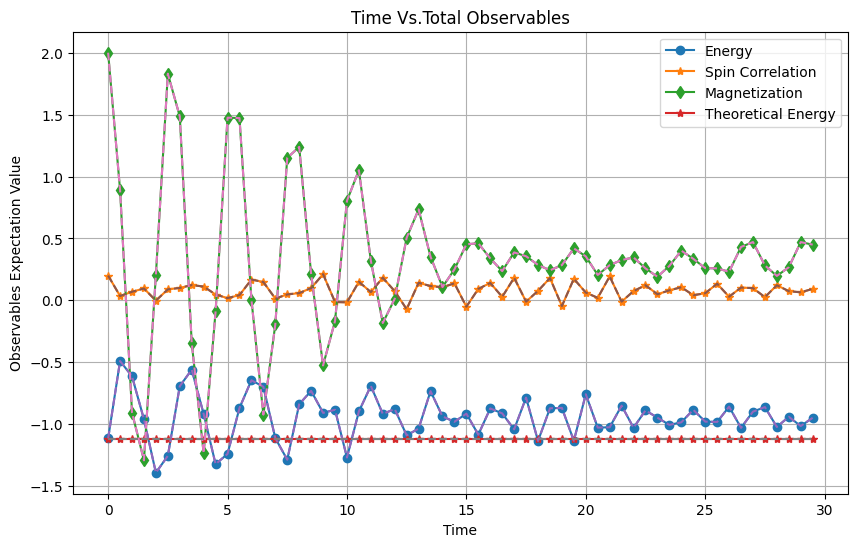

In [18]:
import numpy as np
import matplotlib.pyplot as plt


# Define the Hamiltonian terms
H_terms = [(-0.2,'IIIIZZ'), (-0.2,'IIIZZI'), (-0.2 ,'IIZZII'), (-0.2,'IZZIII'), (-0.2,'ZZIIII'),
               (-0.459,'IIIIIZ'), (-0.459,'IIIIZI'), ( -0.459,'IIIZII'), (-0.459,'IIZIII'), (-0.459,'IZIIII'), ( -0.459,'ZIIIII'), 
               (-1.109,'IIIIIX'), (-1.109,'IIIIXI'), (-1.109,'IIIXII'), (-1.109,'IIXIII'), (-1.109,'IXIIII'), (-1.109,'XIIIII')]


H_terms_spin_correlation = [(0.2,'IIIIZZ'), (0.2,'IIIZZI'), (0.2,'IIZZII'), (0.2,'IZZIII'), (0.2,'ZZIIII')]

H_terms_magnetization = [(1,'IIIIIZ'), (1,'IIIIZI'), (1,'IIIZII'), (1,'IIZIII'), (1,'IZIIII'), (1, 'ZIIIII')]

H_terms_multiple = [H_terms, H_terms_spin_correlation, H_terms_magnetization] #pass this into a function, and check if each term is in.

H_terms_names = ["Energy", "Spin Correlation", "Magnetization"]


n_spins = 6

# Initial state (|psi>)
initial_state = [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j]

def test_2_quantum(initial_state, H_terms, step, time_step):
    qc = QuantumCircuit(6) 
    qc = create_quantum_test_circuit(initial_state, H_terms, step, time_step)

    # Obtain the estimated energy by executing the circuit on the backend

    observables = estimate_expectation2(backend, qc, H_terms_multiple, num_shots=10000)

    # Theoretical energy (for comparison)
    theoretical_energy = compute_theoretical_energy2()
    
    return observables, theoretical_energy[0]

time_values = []
theoretical_energies = []
observables_list = []

for i in range(len(H_terms_multiple)):
    observables_list.append([])

#total evolution time
total_evolution_time = 30
step_size = 0.5

#total number of trotter steps
num_steps = int(total_evolution_time / step_size)

#time for each trotter step
time_step = total_evolution_time / num_steps

for step in range(num_steps):
    print(".", end="")
    
    time_values.append(step * time_step)
    
    observables, theoretical_energy = test_2_quantum(initial_state, H_terms, step, time_step)
    
    for j in range(len(observables)):
        observables_list[j].append(observables[j])
    
    theoretical_energies.append(theoretical_energy)
        

print("")

########### Plot

# Plot the results
plt.figure(figsize=(10, 6))

marker=['o', '*', 'd', '1', '2']

#####
for i in range(len(H_terms_multiple)):
    plt.plot(time_values, observables_list[i], label= H_terms_names[i], marker=marker[i])

plt.plot(time_values, theoretical_energies, label='Theoretical Energy', marker='*')

#####
for j in range(len(H_terms_multiple)):
    plt.plot(time_values, observables_list[j], linestyle='--')
    
plt.plot(time_values, theoretical_energies, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Observables Expectation Value')
plt.title('Time Vs.Total Observables')
plt.legend()
plt.grid(True)
plt.show()
##think of the units!!

### -----------------------------------------------------------------------------------------------